 <h1>Bayesian linear regression model 

## Linear regression background 

consider a simple Bayesian linear regression model with normal priors on the parameters. We are interested in predicting outcomes Y as normally-distributed observations with an expected value μ that is a linear function of two predictor variables, $X_1$ and $X_2$ 




$$ Y \sim \mathcal{N}(\mu,\sigma^2) \\
\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$$


where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X$. while $\sigma$ represents the observation or measurement error. We will apply zero-mean normal priors with variance of 10 to both regression coefficients, which corresponds to weak information regarding the true parameter values. Since variances must be positive, we will also choose a half-normal distribution (normal distribution bounded below at zero) as the prior for $\sigma$.

$$ \sigma \sim \mathcal{N}(0,10)\\
\beta_i \sim \mathcal{N}(0,10)\\
\sigma \sim |\mathcal{N}(0,1)|$$

## import package 

In [18]:
#!conda install -c conda-forge arviz 
import arviz 
print(arviz)
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import numpy as np
from scipy.special import expit
from pymc3 import Model, Normal, HalfNormal
from pymc3 import find_MAP
from scipy import optimize
print(f"Running on PyMC v{pm.__version__}")

<module 'arviz' from '/Users/rubyliu/opt/anaconda3/envs/pm3env/lib/python3.8/site-packages/arviz/__init__.py'>
Running on PyMC v3.11.5


## initialize prior 

In [16]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


/var/folders/c4/b7s1ltp95r1bgvjgv57b95lw0000gn/T/ipykernel_36815/775224226.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


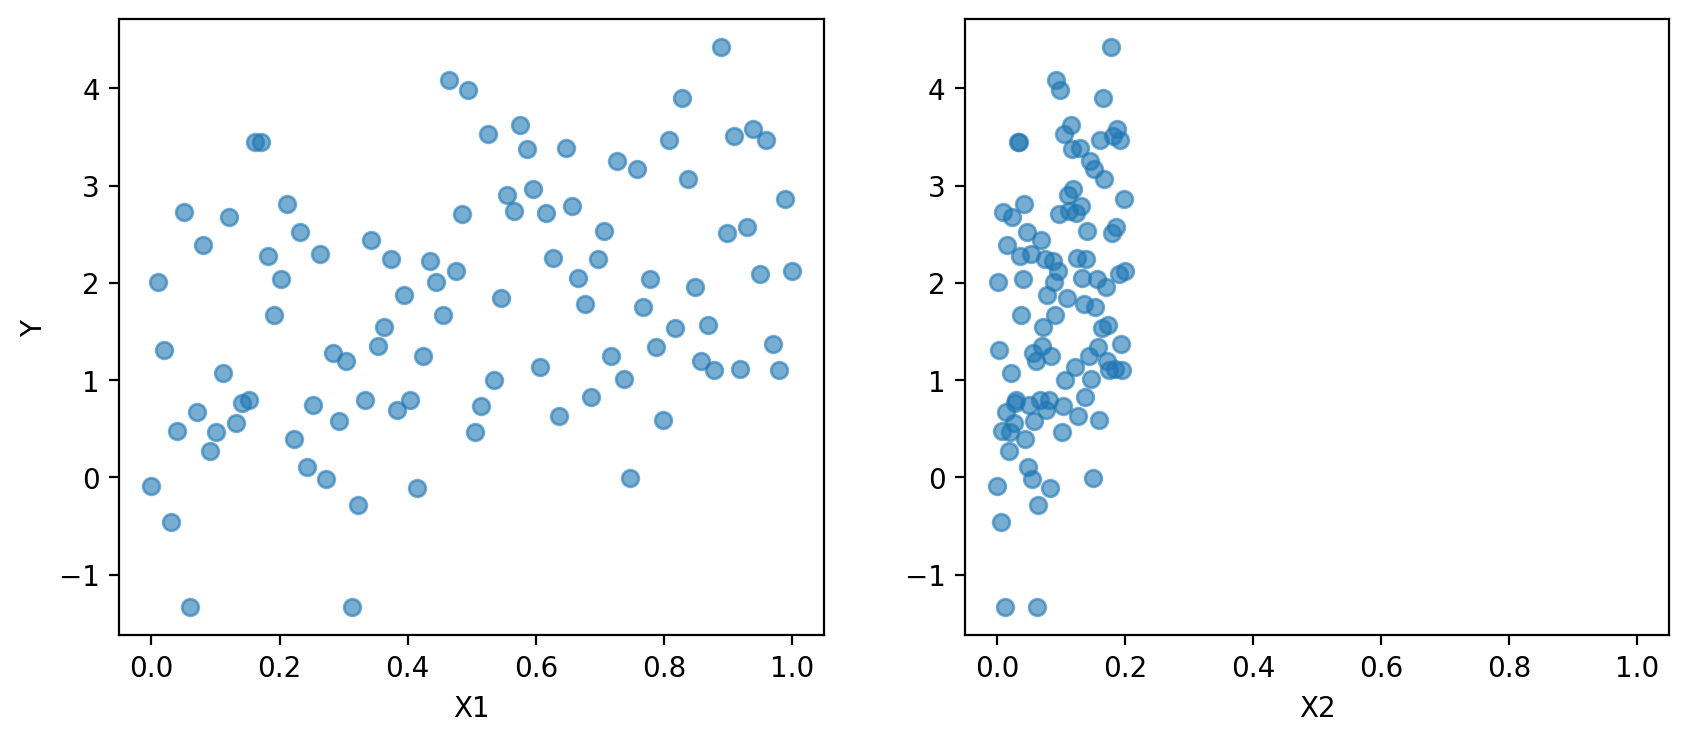

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")
fig.show()

## model implementation 

In [19]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

## model fitting 
Maximum a posteriori methods (MAP)

### original estimate for the model (method='L-BFGS-B')
Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module


$\alpha$: 1.01365899

$\beta$: [1.46792489, 0.29358498]

$\sigma_{log}$: 0.11438772

$\sigma$: 1.12118675

In [20]:
map_estimate = find_MAP(model=basic_model)
print(map_estimate)


{'alpha': array(1.01365899), 'beta': array([1.46792489, 0.29358498]), 'sigma_log__': array(0.11438772), 'sigma': array(1.12118675)}


### Powell’s method to find the MAP

$\alpha$: 1.01761779

$\beta$: [1.51424081, 0.03486478]

$\sigma_{log}$: 0.11323002

$\sigma$: 1.1198895

In [23]:
map_estimate_BFGS = find_MAP(model=basic_model, method="Powell")

print(map_estimate_BFGS)

/Users/rubyliu/opt/anaconda3/envs/pm3env/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,



{'alpha': array(1.01761779), 'beta': array([1.51424081, 0.03486478]), 'sigma_log__': array(0.11323002), 'sigma': array(1.1198895)}


## NUTS
use NUTS to sample 500 draws from the posterior using the MAP as the starting and scaling point. Sampling must also be performed inside the context of the model.

In [32]:
from pymc3 import NUTS, sample

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(method="Powell")

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(1000, step, start=start)

/Users/rubyliu/opt/anaconda3/envs/pm3env/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


/var/folders/c4/b7s1ltp95r1bgvjgv57b95lw0000gn/T/ipykernel_36815/149937335.py:12: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = sample(1000, step, start=start)
/Users/rubyliu/opt/anaconda3/envs/pm3env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

/var/folders/c4/b7s1ltp95r1bgvjgv57b95lw0000gn/T/ipykernel_36815/3102774515.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/rubyliu/opt/anaconda3/envs/pm3env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

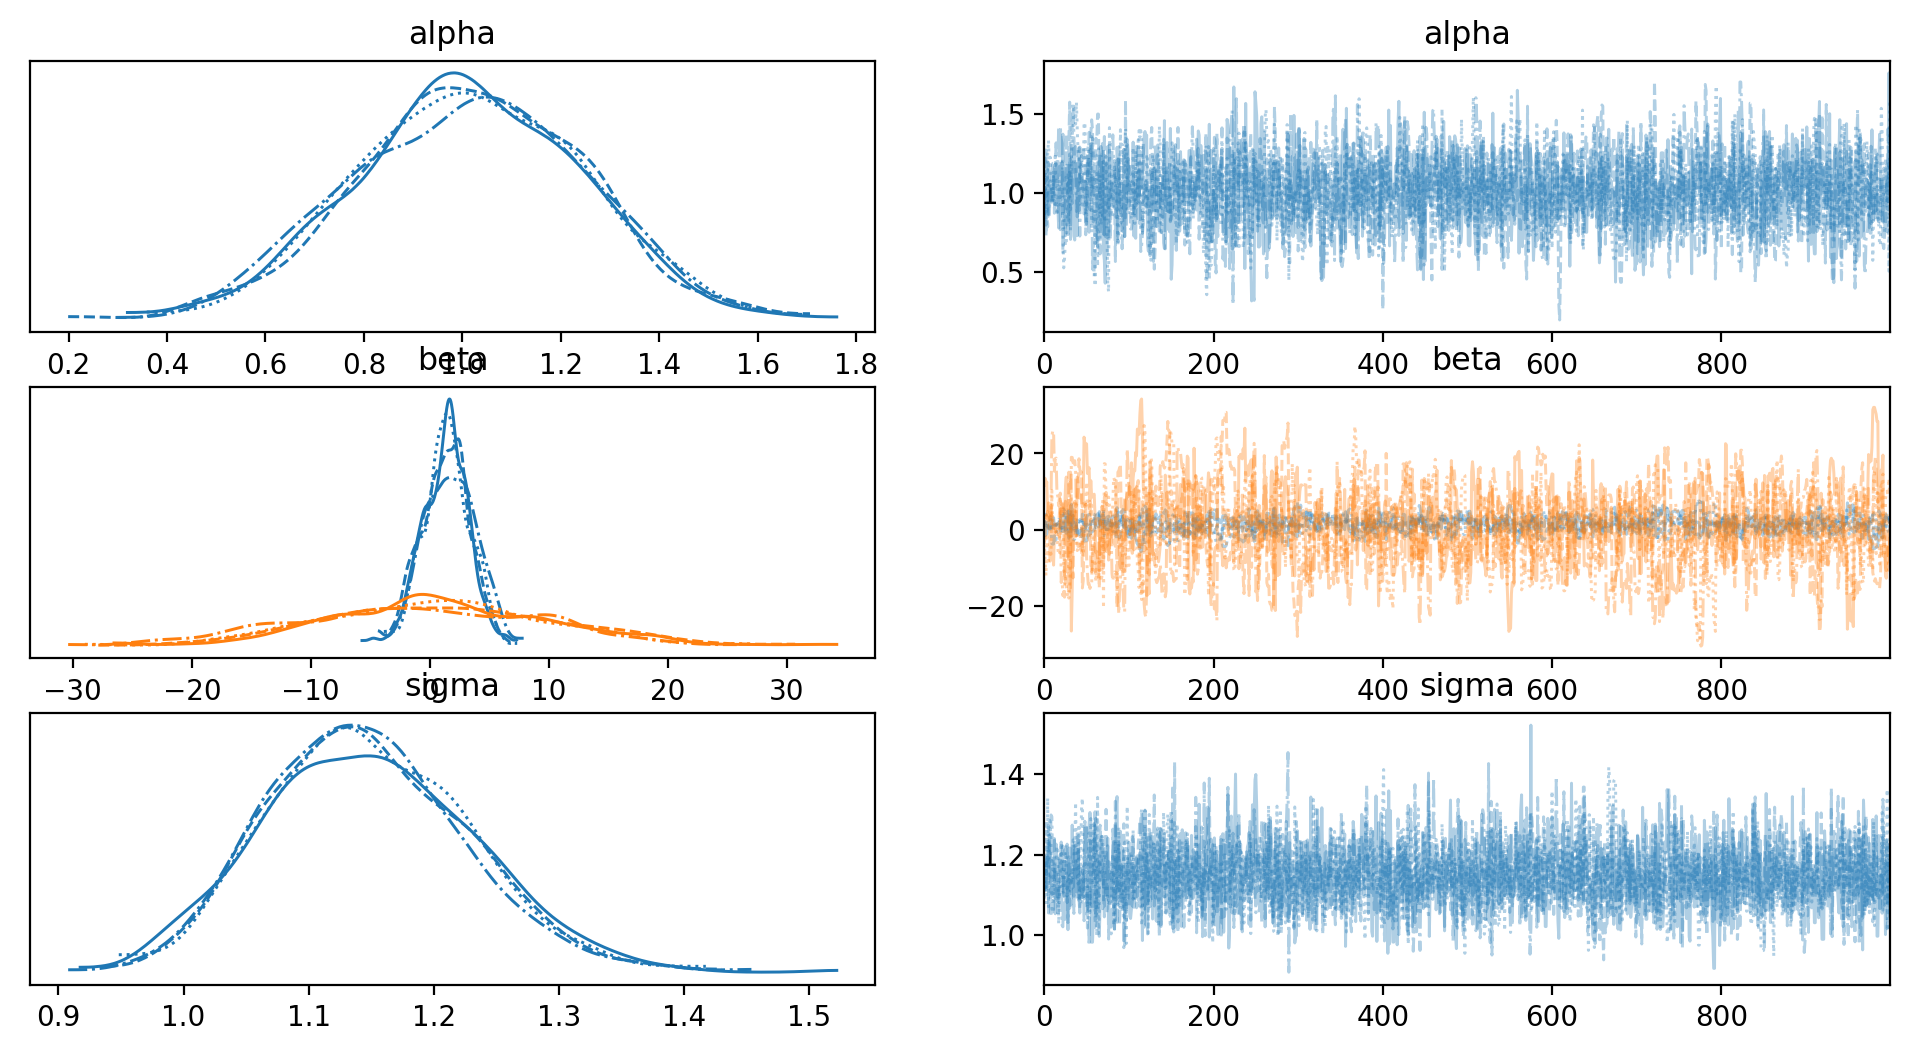

In [33]:
from pymc3 import traceplot

traceplot(trace)

In [34]:
from pymc3 import summary

summary(trace['alpha'])

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.014,0.23,0.605,1.455,0.005,0.003,2424.0,2099.0,NaN
